Replicating figure 6 from [biorxiv paper](https://www.biorxiv.org/content/10.1101/198366v1.full) 

![figure 6](https://www.biorxiv.org/content/biorxiv/early/2017/10/05/198366/F28.large.jpg?download=true)

In [1]:
#%pip install brian2
#%pip install matplotlib

In [1]:
from brian2 import *
import matplotlib.pyplot as plt

#set_device('cpp_standalone', directory=None)  # Use fast "C++ standalone mode"

In [2]:
#Brain2 docs plot utils 
def adjust_spines(ax, spines, position=5):
    """
    Set custom visibility and position of axes

    ax       : Axes
     Axes handle
    spines   : List
     String list of 'left', 'bottom', 'right', 'top' spines to show
    position : Integer
     Number of points for position of axis
    """
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', position))
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    elif 'right' in spines:
        ax.yaxis.set_ticks_position('right')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
        ax.tick_params(axis='y', which='both', left='off', right='off')

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    elif 'top' in spines:
        ax.xaxis.set_ticks_position('top')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])
        ax.tick_params(axis='x', which='both', bottom='off', top='off')


def adjust_ylabels(ax,x_offset=0):
    '''
    Scan all ax list and identify the outmost y-axis position.
    Setting all the labels to that position + x_offset.
    '''

    xc = 0.0
    for a in ax:
        xc = min(xc, (a.yaxis.get_label()).get_position()[0])

    for a in ax:
        a.yaxis.set_label_coords(xc + x_offset,
                                 (a.yaxis.get_label()).get_position()[1])

## Model Parameters

In [3]:
### General parameters
N_e = 3200                   # Number of excitatory neurons
N_i = 800                    # Number of inhibitory neurons
N_a = 3200                   # Number of astrocytes

## Some metrics parameters needed to establish proper connections
size = 3.75*mmeter           # Length and width of the square lattice
distance = 50*umeter         # Distance between neurons

### Neuron parameters
E_l = -60*mV                 # Leak reversal potential
g_l = 9.99*nS                # Leak conductance
E_e = 0*mV                   # Excitatory synaptic reversal potential
E_i = -80*mV                 # Inhibitory synaptic reversal potential
C_m = 198*pF                 # Membrane capacitance
tau_e = 5*ms                 # Excitatory synaptic time constant
tau_i = 10*ms                # Inhibitory synaptic time constant
tau_r = 5*ms                 # Refractory period
I_ex = 100*pA                # External current
V_th = -50*mV                # Firing threshold
V_r = E_l                    # Reset potential

### Synapse parameters
rho_c = 0.005                # Synaptic vesicle-to-extracellular space volume ratio
Y_T = 500.*mmolar            # Total vesicular neurotransmitter concentration
Omega_c = 40/second          # Neurotransmitter clearance rate
U_0__star = 0.6              # Resting synaptic release probability
Omega_f = 3.33/second        # Synaptic facilitation rate
Omega_d = 2.0/second         # Synaptic depression rate
w_e = 0.05*nS                # Excitatory synaptic conductance
w_i = 1.0*nS                 # Inhibitory synaptic conductance
# --- Presynaptic receptors
O_G = 1.5/umolar/second      # Agonist binding (activating) rate
Omega_G = 0.5/(60*second)    # Agonist release (deactivating) rate

### Astrocyte parameters
# ---  Calcium fluxes
O_P = 0.9*umolar/second      # Maximal Ca^2+ uptake rate by SERCAs
K_P = 0.05*umolar            # Ca2+ affinity of SERCAs
C_T = 2*umolar               # Total cell free Ca^2+ content
rho_A = 0.18                 # ER-to-cytoplasm volume ratio
Omega_C = 6/second           # Maximal rate of Ca^2+ release by IP_3Rs
Omega_L = 0.1/second         # Maximal rate of Ca^2+ leak from the ER
# --- IP_3R kinectics
d_1 = 0.13*umolar            # IP_3 binding affinity
d_2 = 1.05*umolar            # Ca^2+ inactivation dissociation constant
O_2 = 0.2/umolar/second      # IP_3R binding rate for Ca^2+ inhibition
d_3 = 0.9434*umolar          # IP_3 dissociation constant
d_5 = 0.08*umolar            # Ca^2+ activation dissociation constant
# --- IP_3 production
# --- Agonist-dependent IP_3 production
O_beta = 0.5*umolar/second   # Maximal rate of IP_3 production by PLCbeta
O_N = 0.3/umolar/second      # Agonist binding rate
Omega_N = 0.5/second         # Maximal inactivation rate
K_KC = 0.5*umolar            # Ca^2+ affinity of PKC
zeta = 10                    # Maximal reduction of receptor affinity by PKC
# --- Endogenous IP3 production
O_delta = 1.2*umolar/second  # Maximal rate of IP_3 production by PLCdelta
kappa_delta = 1.5*umolar     # Inhibition constant of PLC_delta by IP_3
K_delta = 0.1*umolar         # Ca^2+ affinity of PLCdelta
# --- IP_3 degradation
Omega_5P = 0.05/second       # Maximal rate of IP_3 degradation by IP-5P
K_D = 0.7*umolar             # Ca^2+ affinity of IP3-3K
K_3K = 1.0*umolar            # IP_3 affinity of IP_3-3K
O_3K = 4.5*umolar/second     # Maximal rate of IP_3 degradation by IP_3-3K
# --- IP_3 diffusion
F = 0.09*umolar/second       # GJC IP_3 permeability
I_Theta = 0.3*umolar         # Threshold gradient for IP_3 diffusion
omega_I = 0.05*umolar        # Scaling factor of diffusion
# --- Gliotransmitter release and time course
C_Theta = 0.5*umolar         # Ca^2+ threshold for exocytosis
Omega_A = 0.6/second         # Gliotransmitter recycling rate
U_A = 0.6                    # Gliotransmitter release probability
G_T = 200*mmolar             # Total vesicular gliotransmitter concentration
rho_e = 6.5e-4               # Astrocytic vesicle-to-extracellular volume ratio
Omega_e = 60/second          # Gliotransmitter clearance rate
alpha = 0.0                  # Gliotransmission nature

## Define HF Stimulus

In [4]:
stimulus = TimedArray([1.0, 1.2, 1.0, 1.0], dt=2*second)
duration = 4*second          # Total simulation time

## Model Definition

In [5]:
### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) + I_ex*stimulus(t))/C_m : volt (unless refractory)
dg_e/dt = -g_e/tau_e : siemens  # post-synaptic excitatory conductance
dg_i/dt = -g_i/tau_i : siemens  # post-synaptic inhibitory conductance
# Neuron position in space
x : meter (constant)
y : meter (constant)
'''
neurons = NeuronGroup(N_e + N_i, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
exc_neurons = neurons[:N_e]
inh_neurons = neurons[N_e:]
# Arrange excitatory neurons in a grid
N_rows = int(sqrt(N_e))
N_cols = N_e//N_rows
grid_dist = (size / N_cols)
exc_neurons.x = '(i // N_rows)*grid_dist - N_rows/2.0*grid_dist'
exc_neurons.y = '(i % N_rows)*grid_dist - N_cols/2.0*grid_dist'
# Random initial membrane potential values and conductances
neurons.v = 'E_l + rand()*(V_th-E_l)'
neurons.g_e = 'rand()*w_e'
neurons.g_i = 'rand()*w_i'

### Synapses
synapses_eqs = '''
# Neurotransmitter
dY_S/dt = -Omega_c * Y_S                                    : mmolar (clock-driven)
# Fraction of activated presynaptic receptors
dGamma_S/dt = O_G * G_A * (1 - Gamma_S) - Omega_G * Gamma_S : 1 (clock-driven)
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S                                    : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available for release:
dx_S/dt = Omega_d *(1 - x_S)                                : 1 (event-driven)
U_0                                                         : 1
# released synaptic neurotransmitter resources:
r_S                                                         : 1
# gliotransmitter concentration in the extracellular space:
G_A                                                         : mmolar
# which astrocyte covers this synapse ?
astrocyte_index : integer (constant)
'''
synapses_action = '''
U_0 = (1 - Gamma_S) * U_0__star + alpha * Gamma_S
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
Y_S += rho_c * Y_T * r_S
'''
exc_syn = Synapses(exc_neurons, neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',
                   method='exact')
exc_syn.connect(True, p=0.05)
exc_syn.x_S = 1.0
inh_syn = Synapses(inh_neurons, neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S',
                   method='exact')
inh_syn.connect(True, p=0.2)
inh_syn.x_S = 1.0
# Connect excitatory synapses to an astrocyte depending on the position of the
# post-synaptic neuron
N_rows_a = int(sqrt(N_a))
N_cols_a = N_a/N_rows_a
grid_dist = size / N_rows_a
exc_syn.astrocyte_index = ('int(x_post/grid_dist) + '
                           'N_cols_a*int(y_post/grid_dist)')
### Astrocytes
# The astrocyte emits gliotransmitter when its Ca^2+ concentration crosses
# a threshold
astro_eqs = '''
# Fraction of activated astrocyte receptors:
dGamma_A/dt = O_N * Y_S * (1 - clip(Gamma_A,0,1)) -
              Omega_N*(1 + zeta * C/(C + K_KC)) * clip(Gamma_A,0,1) : 1
# Intracellular IP_3
dI/dt = J_beta + J_delta - J_3K - J_5P + J_coupling              : mmolar
J_beta = O_beta * Gamma_A                                        : mmolar/second
J_delta = O_delta/(1 + I/kappa_delta) * C**2/(C**2 + K_delta**2) : mmolar/second
J_3K = O_3K * C**4/(C**4 + K_D**4) * I/(I + K_3K)                : mmolar/second
J_5P = Omega_5P*I                                                : mmolar/second
# Diffusion between astrocytes:
J_coupling                                                       : mmolar/second

# Ca^2+-induced Ca^2+ release:
dC/dt = J_r + J_l - J_p                                   : mmolar
dh/dt = (h_inf - h)/tau_h                                 : 1
J_r = (Omega_C * m_inf**3 * h**3) * (C_T - (1 + rho_A)*C) : mmolar/second
J_l = Omega_L * (C_T - (1 + rho_A)*C)                     : mmolar/second
J_p = O_P * C**2/(C**2 + K_P**2)                          : mmolar/second
m_inf = I/(I + d_1) * C/(C + d_5)                         : 1
h_inf = Q_2/(Q_2 + C)                                     : 1
tau_h = 1/(O_2 * (Q_2 + C))                               : second
Q_2 = d_2 * (I + d_1)/(I + d_3)                           : mmolar

# Fraction of gliotransmitter resources available for release:
dx_A/dt = Omega_A * (1 - x_A) : 1
# gliotransmitter concentration in the extracellular space:
dG_A/dt = -Omega_e*G_A        : mmolar
# Neurotransmitter concentration in the extracellular space:
Y_S                           : mmolar
# The astrocyte position in space
x : meter (constant)
y : meter (constant)
'''
glio_release = '''
G_A += rho_e * G_T * U_A * x_A
x_A -= U_A *  x_A
'''
astrocytes = NeuronGroup(N_a, astro_eqs,
                         # The following formulation makes sure that a "spike" is
                         # only triggered at the first threshold crossing
                         threshold='C>C_Theta',
                         refractory='C>C_Theta',
                         # The gliotransmitter release happens when the threshold
                         # is crossed, in Brian terms it can therefore be
                         # considered a "reset"
                         reset=glio_release,
                         method='rk4',
                         dt=1e-2*second)
# Arrange astrocytes in a grid
astrocytes.x = '(i // N_rows_a)*grid_dist - N_rows_a/2.0*grid_dist'
astrocytes.y = '(i % N_rows_a)*grid_dist - N_cols_a/2.0*grid_dist'
# Add random initialization
astrocytes.C = 0.01*umolar
astrocytes.h = 0.9
astrocytes.I = 0.01*umolar
astrocytes.x_A = 1.0

ecs_astro_to_syn = Synapses(astrocytes, exc_syn,
                            'G_A_post = G_A_pre : mmolar (summed)')
ecs_astro_to_syn.connect('i == astrocyte_index_post')
ecs_syn_to_astro = Synapses(exc_syn, astrocytes,
                            'Y_S_post = Y_S_pre/N_incoming : mmolar (summed)')
ecs_syn_to_astro.connect('astrocyte_index_pre == j')
# Diffusion between astrocytes
astro_to_astro_eqs = '''
delta_I = I_post - I_pre            : mmolar
J_coupling_post = -(1 + tanh((abs(delta_I) - I_Theta)/omega_I))*
                  sign(delta_I)*F/2 : mmolar/second (summed)
'''
astro_to_astro = Synapses(astrocytes, astrocytes,
                          model=astro_to_astro_eqs)
# Connect to all astrocytes less than 75um away
# (about 4 connections per astrocyte)
astro_to_astro.connect('i != j and '
                       'sqrt((x_pre-x_post)**2 +'
                       '     (y_pre-y_post)**2) < 75*um')

## Monitors

In [6]:
# Note that we could use a single monitor for all neurons instead, but this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(exc_neurons)
inh_mon = SpikeMonitor(inh_neurons)
ast_mon = SpikeMonitor(astrocytes)

## Simulation Run

In [7]:
run(duration, report='text')

Starting simulation at t=0. s for a duration of 8. s
252.1 ms (3%) simulated in 10s, estimated 5m 7s remaining.
0.5031 s (6%) simulated in 20s, estimated 4m 58s remaining.
0.7536 s (9%) simulated in 30s, estimated 4m 49s remaining.
1.0055 s (12%) simulated in 40s, estimated 4m 38s remaining.
1.2555 s (15%) simulated in 50s, estimated 4m 29s remaining.
1.5047 s (18%) simulated in 1m 0s, estimated 4m 19s remaining.
1.757 s (21%) simulated in 1m 10s, estimated 4m 9s remaining.
2.0082 s (25%) simulated in 1m 20s, estimated 3m 59s remaining.
2.2589 s (28%) simulated in 1m 30s, estimated 3m 49s remaining.
2.4653 s (30%) simulated in 1m 40s, estimated 3m 45s remaining.
2.6292 s (32%) simulated in 1m 50s, estimated 3m 45s remaining.
2.8667 s (35%) simulated in 2m 0s, estimated 3m 35s remaining.
3.1182 s (38%) simulated in 2m 10s, estimated 3m 24s remaining.
3.3668 s (42%) simulated in 2m 20s, estimated 3m 13s remaining.
3.6168 s (45%) simulated in 2m 30s, estimated 3m 2s remaining.
3.8691 s (4

## Plot of Spiking Activity

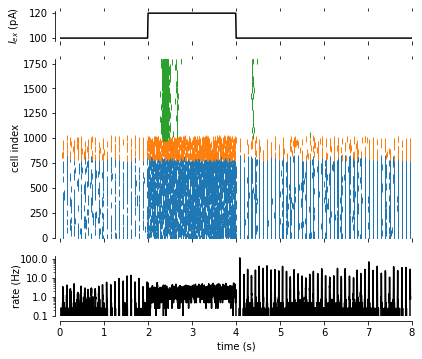

In [8]:
#plt.style.use('figures.mplstyle')

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6.26894, 6.26894*0.8),
                       gridspec_kw={'height_ratios': [1, 6, 2],
                                    'left': 0.12, 'top': 0.97})
time_range = np.linspace(0, duration/second, int(duration/second*100))*second
ax[0].plot(time_range, I_ex*stimulus(time_range)/pA, 'k')
ax[0].set(xlim=(0, duration/second), ylim=(98, 122),
          yticks=[100, 120], ylabel='$I_{ex}$ (pA)')
adjust_spines(ax[0], ['left'])

## We only plot a fraction of the spikes
fraction = 4
ax[1].plot(exc_mon.t[exc_mon.i <= N_e//fraction]/second,
           exc_mon.i[exc_mon.i <= N_e//fraction], '|', color='C0')
ax[1].plot(inh_mon.t[inh_mon.i <= N_i//fraction]/second,
           inh_mon.i[inh_mon.i <= N_i//fraction]+N_e//fraction, '|', color='C1')
ax[1].plot(ast_mon.t[ast_mon.i <= N_a//fraction]/second,
           ast_mon.i[ast_mon.i <= N_a//fraction]+(N_e+N_i)//fraction,
           '|', color='C2')
ax[1].set(xlim=(0, duration/second), ylim=[0, (N_e+N_i+N_a)//fraction],
          yticks=np.arange(0, (N_e+N_i+N_a)//fraction+1, 250),
          ylabel='cell index')
adjust_spines(ax[1], ['left'])

# Generate frequencies
bin_size = 1*ms
spk_count, bin_edges = np.histogram(np.r_[exc_mon.t/second, inh_mon.t/second],
                                    int(duration/bin_size))
rate = 1.0*spk_count/(N_e + N_i)/bin_size/Hz
rate[rate<0.001] = 0.001 # Fix 0 lower bound for log scale
ax[2].semilogy(bin_edges[:-1], rate, '-', color='k')
adjust_spines(ax[2], ['left', 'bottom'])
ax[2].set(xlim=(0, duration/second), ylim=(0.1, 150),
          xticks=np.arange(0, 9), yticks=[0.1, 1, 10, 100],
          xlabel='time (s)', ylabel='rate (Hz)')
ax[2].get_yaxis().set_major_formatter(ScalarFormatter())

adjust_ylabels(ax, x_offset=-0.11)

plt.show()

## Simulation 2: Low Astro Coupling

In [9]:
# ### Astrocytes
# # The astrocyte emits gliotransmitter when its Ca^2+ concentration crosses
# # a threshold
# astro_eqs = '''
# # Fraction of activated astrocyte receptors:
# dGamma_A/dt = O_N * Y_S * (1 - clip(Gamma_A,0,1)) -
#               Omega_N*(1 + zeta * C/(C + K_KC)) * clip(Gamma_A,0,1) : 1
# # Intracellular IP_3
# dI/dt = J_beta + J_delta - J_3K - J_5P + J_coupling * 0.5             : mmolar
# J_beta = O_beta * Gamma_A                                        : mmolar/second
# J_delta = O_delta/(1 + I/kappa_delta) * C**2/(C**2 + K_delta**2) : mmolar/second
# J_3K = O_3K * C**4/(C**4 + K_D**4) * I/(I + K_3K)                : mmolar/second
# J_5P = Omega_5P*I                                                : mmolar/second
# # Diffusion between astrocytes:
# J_coupling                                                       : mmolar/second

# # Ca^2+-induced Ca^2+ release:
# dC/dt = J_r + J_l - J_p                                   : mmolar
# dh/dt = (h_inf - h)/tau_h                                 : 1
# J_r = (Omega_C * m_inf**3 * h**3) * (C_T - (1 + rho_A)*C) : mmolar/second
# J_l = Omega_L * (C_T - (1 + rho_A)*C)                     : mmolar/second
# J_p = O_P * C**2/(C**2 + K_P**2)                          : mmolar/second
# m_inf = I/(I + d_1) * C/(C + d_5)                         : 1
# h_inf = Q_2/(Q_2 + C)                                     : 1
# tau_h = 1/(O_2 * (Q_2 + C))                               : second
# Q_2 = d_2 * (I + d_1)/(I + d_3)                           : mmolar

# # Fraction of gliotransmitter resources available for release:
# dx_A/dt = Omega_A * (1 - x_A) : 1
# # gliotransmitter concentration in the extracellular space:
# dG_A/dt = -Omega_e*G_A        : mmolar
# # Neurotransmitter concentration in the extracellular space:
# Y_S                           : mmolar
# # The astrocyte position in space
# x : meter (constant)
# y : meter (constant)
# '''
# glio_release = '''
# G_A += rho_e * G_T * U_A * x_A
# x_A -= U_A *  x_A
# '''

## Set Up and Run Network

Set up network and run while iterating through different Astro-Astro connection strengths

In [ ]:
input_range = range(0,10)

output_rates = []

for input in input_range:

    astrocytes = NeuronGroup(N_a, astro_eqs,
                            # The following formulation makes sure that a "spike" is
                            # only triggered at the first threshold crossing
                            threshold='C>C_Theta',
                            refractory='C>C_Theta',
                            # The gliotransmitter release happens when the threshold
                            # is crossed, in Brian terms it can therefore be
                            # considered a "reset"
                            reset=glio_release,
                            method='rk4',
                            dt=1e-2*second)
    # Arrange astrocytes in a grid
    astrocytes.x = '(i // N_rows_a)*grid_dist - N_rows_a/2.0*grid_dist'
    astrocytes.y = '(i % N_rows_a)*grid_dist - N_cols_a/2.0*grid_dist'
    # Add random initialization1
    astrocytes.C = 0.01*umolar
    astrocytes.h = 0.9
    astrocytes.I = 0.01*umolar
    astrocytes.x_A = 1.0

    ecs_astro_to_syn = Synapses(astrocytes, exc_syn,
                                'G_A_post = G_A_pre : mmolar (summed)')
    ecs_astro_to_syn.connect('i == astrocyte_index_post')
    ecs_syn_to_astro = Synapses(exc_syn, astrocytes,
                                'Y_S_post = Y_S_pre/N_incoming : mmolar (summed)')
    ecs_syn_to_astro.connect('astrocyte_index_pre == j')
    # Diffusion between astrocytes
    astro_to_astro_eqs = '''
    delta_I = I_post - I_pre            : mmolar
    J_coupling_post = -(1 + tanh((abs(delta_I) - I_Theta)/omega_I))*
                    sign(delta_I)*F/2 : mmolar/second (summed)
    '''
    astro_to_astro = Synapses(astrocytes, astrocytes,
                            model=astro_to_astro_eqs)
    # Connect to all astrocytes less than 75um away
    # (about 4 connections per astrocyte)
    astro_to_astro.connect('i != j and '
                        'sqrt((x_pre-x_post)**2 +'
                        '     (y_pre-y_post)**2) < 75*um')

    #Run the simulation
    run(duration, report='text')

    #compute firing rate
    spk_count, bin_edges = np.histogram(np.r_[exc_mon.t/second, inh_mon.t/second],
                                    int(duration/bin_size))
    rate = 1.0*spk_count/(N_e + N_i)/bin_size/Hz
    rate[rate<0.001] = 0.001 # Fix 0 lower bound for log scale

    #append the rate from this simulation to the output array
    output_rates.append(rate)

In [10]:
run(duration, report='text')

MagicError: The magic network contains a mix of objects that has been run before and new objects, Brian does not know whether you want to start a new simulation or continue an old one. Consider explicitly creating a Network object. Also note that you can find out which objects will be included in a magic network with the collect() function.

## Plot with reduced coupling

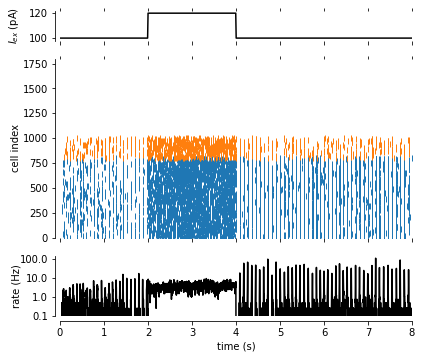

In [ ]:
#plt.style.use('figures.mplstyle')

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6.26894, 6.26894*0.8),
                       gridspec_kw={'height_ratios': [1, 6, 2],
                                    'left': 0.12, 'top': 0.97})
time_range = np.linspace(0, duration/second, int(duration/second*100))*second
ax[0].plot(time_range, I_ex*stimulus(time_range)/pA, 'k')
ax[0].set(xlim=(0, duration/second), ylim=(98, 122),
          yticks=[100, 120], ylabel='$I_{ex}$ (pA)')
adjust_spines(ax[0], ['left'])

## We only plot a fraction of the spikes
fraction = 4
ax[1].plot(exc_mon.t[exc_mon.i <= N_e//fraction]/second,
           exc_mon.i[exc_mon.i <= N_e//fraction], '|', color='C0')
ax[1].plot(inh_mon.t[inh_mon.i <= N_i//fraction]/second,
           inh_mon.i[inh_mon.i <= N_i//fraction]+N_e//fraction, '|', color='C1')
ax[1].plot(ast_mon.t[ast_mon.i <= N_a//fraction]/second,
           ast_mon.i[ast_mon.i <= N_a//fraction]+(N_e+N_i)//fraction,
           '|', color='C2')
ax[1].set(xlim=(0, duration/second), ylim=[0, (N_e+N_i+N_a)//fraction],
          yticks=np.arange(0, (N_e+N_i+N_a)//fraction+1, 250),
          ylabel='cell index')
adjust_spines(ax[1], ['left'])

# Generate frequencies
bin_size = 1*ms
spk_count, bin_edges = np.histogram(np.r_[exc_mon.t/second, inh_mon.t/second],
                                    int(duration/bin_size))
rate = 1.0*spk_count/(N_e + N_i)/bin_size/Hz
rate[rate<0.001] = 0.001 # Fix 0 lower bound for log scale
ax[2].semilogy(bin_edges[:-1], rate, '-', color='k')
adjust_spines(ax[2], ['left', 'bottom'])
ax[2].set(xlim=(0, duration/second), ylim=(0.1, 150),
          xticks=np.arange(0, 9), yticks=[0.1, 1, 10, 100],
          xlabel='time (s)', ylabel='rate (Hz)')
ax[2].get_yaxis().set_major_formatter(ScalarFormatter())

adjust_ylabels(ax, x_offset=-0.11)

plt.show()

It looks like this prevents cells 1000-1750 (I think these are the astrocytes) from ever releasing any gliotransmitter and is thus like not having astrocytes at all.